1.3.2. Phase 2: Policy Document Indexing for RAG

Index benefits policy PDFs for Retrieval-Augmented Generation (RAG) to enable
efficient policy retrieval.

Text Extraction: Use PyPDF2 to extract text from policy PDFs, removing noise
(e.g., page numbers).

Text Preprocessing: Segment text into chunks (e.g., 200 words per chunk).

Vector Store Creation: Build a Chroma vector store using embeddings from 
sentence-transformers or OpenAI.

Retrieval Testing: Test retrieval with 5 HR policy queries (e.g., “What is the
eligibility for Tuition Reimbursement?”) and evaluate chunk relevance.

In [6]:
#!pip install PyPDF2
#!pip install -qU "langchain-chroma"
#!pip install -qU langchain-openai
!pip install -qU langchain==0.3.26
!pip install -qU langchain-community==0.3.27
!pip install -qU langchain-core==0.3.74
!pip install -qU langchain-openai==0.3.24
!pip install -qU langchain-text-splitters==0.3.8
!pip install langgraph

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-chroma 0.2.5 requires langchain-core>=0.3.70, but you have langchain-core 0.3.68 which is incompatible.
langchain-openai 0.3.31 requires langchain-core<1.0.0,>=0.3.74, but you have langchain-core 0.3.68 which is incompatible.
langchain-text-splitters 0.3.9 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 0.3.68 which is incompatible.


In [1]:
from PyPDF2 import PdfReader
from langchain_text_splitters import RecursiveCharacterTextSplitter,CharacterTextSplitter
import os
import pandas as pd

directory_path = './assets/benefits/' 

pdf_rows = []
text_splitter = CharacterTextSplitter(separator='\n\n',chunk_size=200,chunk_overlap=0)

for filename in os.listdir(directory_path):
    if filename.endswith('.pdf'):
        full_path = os.path.join(directory_path, filename)
        print(f"Found PDF: {full_path}")
        reader = PdfReader(full_path)
        total_pages = len(reader.pages)
        print(f"Total pages: {total_pages}")
        for i in range(total_pages):
            chunk_num = 0
            page_text = reader.pages[i].extract_text()
            page_text = page_text.replace("Introduction", '')
            chunks = text_splitter.split_text(page_text)
            policy_name = filename.replace("policy.pdf","")
            for c in chunks:
                pdf_rows.append({'policy': policy_name, 'page': i, 'chunk': chunk_num,'text': c})
                chunk_num+=1
policy_pdfs = pd.DataFrame(pdf_rows)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Found PDF: ./assets/benefits/gym-policy.pdf
Total pages: 7
Found PDF: ./assets/benefits/life-insurance-policy.pdf
Total pages: 8
Found PDF: ./assets/benefits/childcare-policy.pdf
Total pages: 8
Found PDF: ./assets/benefits/401k-retirement-policy.pdf
Total pages: 9
Found PDF: ./assets/benefits/work-from-home-policy.pdf
Total pages: 7
Found PDF: ./assets/benefits/vacation-policy.pdf
Total pages: 7
Found PDF: ./assets/benefits/health-insurance-policy.pdf
Total pages: 7
Found PDF: ./assets/benefits/tuition-reimbursement-policy.pdf
Total pages: 8


In [30]:
import getpass
import os
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from uuid import uuid4
import chromadb
from langchain.chat_models import init_chat_model

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
if not os.environ.get("CHROMA_API_KEY"):
    os.environ["CHROMA_API_KEY"] = getpass.getpass("Enter API key for Chroma: ")
if not os.environ.get("CHROMA_TENANT"):
    os.environ["CHROMA_TENANT"]= getpass.getpass("Enter tenant for Chroma: ")
os.environ["CHROMA_DATABASE"]= 'policy_details'

#set to true for tracing
os.environ["LANGSMITH_TRACING"] = "false"
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"]="employee-chatbot"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter API key for Langsmith: ")
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

vector_store = Chroma(collection_name="policy_embeddings",embedding_function=embeddings, chroma_cloud_api_key=os.getenv("CHROMA_API_KEY"),
tenant=os.getenv("CHROMA_TENANT"),database=os.getenv("CHROMA_DATABASE"))

### Run once to create vector store in Chroma Cloud ###

In [10]:
docs = []
idx = 0
#vector_store.delete(ids=uuids[:-1])
for row in policy_pdfs.itertuples():
    doc = Document(page_content=row.text, metadata={'policy': row.policy, 'page': row.page, 'chunk_num' : row.chunk}, id=idx)
    docs.append(doc)
    idx+=1
uuids = [str(uuid4()) for _ in range(len(docs))]
vector_store.add_documents(documents=docs, ids=uuids)

Enter API key for Chroma:  ········
Enter tenant for Chroma:  ········


['1d487c85-2cb0-4261-96a3-aa64102a4384',
 '7646add7-958a-4694-82f6-56acde691d1f',
 'd3d67761-e8e9-44d3-827d-59a00f7c004c',
 '88702191-998d-41e7-a645-b1fde8ed4d28',
 'f62209a3-eaab-40e8-899e-8f341a5776d4',
 '54f15c2d-dbac-4c35-b72d-015aaffdf189',
 'eb166803-6216-4902-800a-b8f5538ba3fa',
 'bd11d47d-dff7-4d29-8769-536de31ca1df',
 '440be405-d0b7-47c9-9335-3b82e2cd959c',
 'c3f1b1da-9802-49ca-89e7-757fd6135cee',
 '2bf1a353-ab3d-4798-b5d6-198e00acdbab',
 'aeaed138-2621-4020-81b5-b43df0c96ab2',
 'a203018b-3e31-4b2e-beee-d9d581dca620',
 '08808b7e-1202-4fdc-9da7-1e743c04b68a',
 '6c239a87-7325-4992-8c50-93261ce67286',
 'f5a3858e-9c1a-44f2-b24d-6eae5d1b48ef',
 '03376ab2-46cd-4da9-b168-52177d0e80ab',
 'b5b9a493-77df-4170-922a-af0e79de5309',
 '47ab4642-e2ec-45a3-b35a-e24528971f7c',
 'ac8ef7e5-8da0-410f-9955-426f629d4c9d',
 '1e05ca34-8d0a-4b20-a296-da514e229ea6',
 '0f8d2192-37f0-401f-a822-a693754c51d9',
 '258a3d18-a525-4bbc-a6c8-cb20f4c72716',
 '9c6e23cd-8e34-433b-97a4-cbdf9b67e909',
 '82536845-3943-

Similarity Search - Prioritize chunks most similar to the query

In [4]:
query_set = ["How do I use the flexible spending account to pay for the gym?","When should beneficiaries be updated for my 401k account?","What are the timings for before and after school child care?","How is HSA useful for retirement?","Can I work from a different state?"]
sim_scores = []
for query in query_set:
    results = vector_store.similarity_search_with_relevance_scores(query, k=3)
    for res, score in results:
    #print(f"* [Similarity ={score:3f}] {res.page_content} [{res.metadata}]")
        sim_scores.append({'query': query, 'Similarity': score, 'chunk': res.page_content,'metadata': res.metadata})
sim_scores = pd.DataFrame(sim_scores)

In [5]:
sim_scores.sort_values(by=['query','Similarity'], ascending=False)

,query,Similarity,chunk,metadata
3,When should beneficiaries be updated for my 40...,0.365133,"information about plan changes, fee disclosure...","{'page': 5, 'policy': '401k-retirement-policy...."
4,When should beneficiaries be updated for my 40...,0.242312,the contribution amounts. You can opt out of a...,"{'page': 2, 'policy': '401k-retirement-policy...."
5,When should beneficiaries be updated for my 40...,0.232417,The 401(k) plan allows loans for participants ...,"{'page': 4, 'policy': '401k-retirement-policy...."
6,What are the timings for before and after scho...,0.256909,can care for children with minor illnesses who...,"{'policy': 'childcare-policy.pdf', 'page': 3}"
7,What are the timings for before and after scho...,0.242390,Eligibility and Enrollment\nAll full-time empl...,"{'policy': 'childcare-policy.pdf', 'page': 5}"
8,What are the timings for before and after scho...,0.241613,Our Family Services coordinator in HR holds mo...,"{'policy': 'childcare-policy.pdf', 'page': 6}"
9,How is HSA useful for retirement?,0.105319,We also provide guidance on coordinating your ...,"{'policy': '401k-retirement-policy.pdf', 'page..."
10,How is HSA useful for retirement?,0.096660,TechLance’s 401(k) retirement plan represents ...,"{'policy': '401k-retirement-policy.pdf', 'page..."
11,How is HSA useful for retirement?,0.089149,the contribution amounts. You can opt out of a...,"{'page': 2, 'policy': '401k-retirement-policy...."
0,How do I use the flexible spending account to ...,0.333307,"In addition to traditional gym memberships, al...","{'page': 2, 'policy': 'gym-policy.pdf'}"


Maximal Marginal Relevance - Optimize for similarity to the query and diversity among documents to remove redundant information.

In [6]:
mmr_scores = []
for query in query_set:
    #lambda_multiplier - closer to one = max query similarity, closer to 0 = max diversity
    results = vector_store.max_marginal_relevance_search(query, k=3, lambda_mult=0.6)
    for doc in results:
    #print(f"* [Similarity ={score:3f}] {res.page_content} [{res.metadata}]")
        mmr_scores.append({'query': query, 'chunk': doc.page_content,'metadata': doc.metadata})
mmr_scores = pd.DataFrame(mmr_scores)

In [8]:
mmr_scores

,query,chunk,metadata
0,How do I use the flexible spending account to ...,"In addition to traditional gym memberships, al...","{'policy': 'gym-policy.pdf', 'page': 2}"
1,How do I use the flexible spending account to ...,The prescription drug coverage varies by plan ...,"{'policy': 'health-insurance-policy.pdf', 'pag..."
2,How do I use the flexible spending account to ...,the contribution amounts. You can opt out of a...,"{'page': 2, 'policy': '401k-retirement-policy...."
3,When should beneficiaries be updated for my 40...,"information about plan changes, fee disclosure...","{'policy': '401k-retirement-policy.pdf', 'page..."
4,When should beneficiaries be updated for my 40...,Beneﬁciary Designations and Claims\nOne of the...,"{'policy': 'life-insurance-policy.pdf', 'page'..."
5,When should beneficiaries be updated for my 40...,This policy is eﬀective immediately and supers...,"{'page': 7, 'policy': 'life-insurance-policy.p..."
6,What are the timings for before and after scho...,can care for children with minor illnesses who...,"{'policy': 'childcare-policy.pdf', 'page': 3}"
7,What are the timings for before and after scho...,Our Family Services coordinator in HR holds mo...,"{'policy': 'childcare-policy.pdf', 'page': 6}"
8,What are the timings for before and after scho...,provide resources for ﬁnding specialized care ...,"{'policy': 'childcare-policy.pdf', 'page': 7}"
9,How is HSA useful for retirement?,We also provide guidance on coordinating your ...,"{'page': 6, 'policy': '401k-retirement-policy...."


### Advanced RAG Techniques ###

1. LOTR (Merger Retriever)
takes a list of retrievers as input and merges the results of their get_relevant_documents() methods into a single list. The merged results will be a list of documents that are relevant to the query and that have been ranked by the different retrievers.
The MergerRetriever class can be used to improve the accuracy of document retrieval by combining the results of multiple retrievers, which can help to reduce the risk of bias in the results and can also rank the results of the different retrievers, so that the most relevant documents are returned first.

2. Use Long Context Reordering
Models can miss relevant information in the middle of the context, so document chunks are reordered in such a way that the most relevant documents are at the beginning and end of the context and less relevant information is in the middle. 

4. Use a Document Compressor to automatically compress the retrieved documents and create a more concise context.

In [9]:
from langchain_community.document_transformers import (EmbeddingsClusteringFilter,EmbeddingsRedundantFilter,)
from langchain.retrievers import (ContextualCompressionRetriever, MergerRetriever,)
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain_community.document_transformers import LongContextReorder

retriever_sim = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 3})
retriever_mmr = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 3, "lambda_mult":0.6})
lotr = MergerRetriever(retrievers=[retriever_sim, retriever_mmr])

#remove redundant chunks
filter = EmbeddingsRedundantFilter(embeddings = OpenAIEmbeddings(model="text-embedding-3-large"))
#reorder the chunks
reordering = LongContextReorder()
pipeline = DocumentCompressorPipeline(transformers=[filter, reordering])
compression_retriever= ContextualCompressionRetriever(base_compressor=pipeline, base_retriever=lotr)

In [10]:
test_query=query_set[3]
retrieved_docs = compression_retriever.invoke(test_query)
print("Query: ",test_query)
for doc in retrieved_docs:
    print(doc.page_content)

Query:  How is HSA useful for retirement?
We also provide guidance on coordinating your 401(k) with other retirement savings vehicles
such as IRAs, health savings accounts, and taxable investment accounts. Creating a
comprehensive retirement strategy often involves multiple account types and tax strategies, and
our educational resources can help you understand how these pieces ﬁt together.
Plan Governance and Fiduciary Responsibility
TechLance takes seriously its ﬁduciary responsibility for the 401(k) plan and regularly monitors
investment performance, fees, and service quality. We work with independent investment
advisors and conduct annual plan reviews to ensure that we’re providing high-quality, cost-
eﬀective retirement beneﬁts.
Plan expenses are shared between TechLance and participants in a way that keeps costs
reasonable while providing excellent service and investment options. Administrative fees are
largely covered by TechLance, while investment management fees (expense ratios

In [103]:
for c in sim_scores[sim_scores['query']==test_query]['chunk']:
    print(c)

We also provide guidance on coordinating your 401(k) with other retirement savings vehicles
such as IRAs, health savings accounts, and taxable investment accounts. Creating a
comprehensive retirement strategy often involves multiple account types and tax strategies, and
our educational resources can help you understand how these pieces ﬁt together.
Plan Governance and Fiduciary Responsibility
TechLance takes seriously its ﬁduciary responsibility for the 401(k) plan and regularly monitors
investment performance, fees, and service quality. We work with independent investment
advisors and conduct annual plan reviews to ensure that we’re providing high-quality, cost-
eﬀective retirement beneﬁts.
Plan expenses are shared between TechLance and participants in a way that keeps costs
reasonable while providing excellent service and investment options. Administrative fees are
largely covered by TechLance, while investment management fees (expense ratios) are deducted
from investment returns. Al

TODO: Ask user which policy they want to ask about, filter by metadata

### Langchain RAG Application ###

Benefits: Support multiple invocation modes (batching, streaming etc.), automatic tracing, persistance for conversations, human-in-the-loop approvals

In [12]:
#Define the state - input data, transferred data, output data
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from langchain_core.prompts import PromptTemplate
from langsmith import traceable

template = """Use ONLY the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Keep the answer as concise as possible.
{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

    def retrieve(state: State):
        retrieved_docs = vector_store.similarity_search(state["question"])
        return {"context": retrieved_docs}


    def generate(state: State):
        docs_content = "\n\n".join(doc.page_content for doc in state["context"])
        messages = prompt.invoke({"question": state["question"], "context": docs_content})
        response = llm.invoke(messages)
        return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([State.retrieve, State.generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

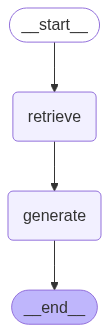

In [13]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
result = graph.invoke({"question": "How do I pay for the gym membership?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='88702191-998d-41e7-a645-b1fde8ed4d28', metadata={'policy': 'gym-policy.pdf', 'page': 2}, page_content='In addition to traditional gym memberships, all TechLance employees and their families have\ncomplimentary access to our curated online ﬁtness platform, which includes workout videos,\nwellness content, and live virtual classes. We also provide premium subscriptions to popular\nﬁtness apps such as Peloton Digital, Nike Training Club, and Headspace for meditation and\nmindfulness training.\nEnrollment Process and Payment Options\nGetting started with our ﬁtness beneﬁts is straightforward, though it requires some planning and\ndocumentation. All active full-time and part-time employees working at least 20 hours per week\nare eligible for ﬁtness beneﬁts immediately upon hire, with no waiting period or probationary\nrequirements.\nTo enroll, employees ﬁrst browse available ﬁtness partners through our beneﬁts portal,\ncomparing locations, amenities, class schedules, 

### Langgraph with Persistance ###
Conversation = sequence of messages.

User Input = Human Message, Vector Store Query = AI Message with tool call, Retrieved docs = Tool Message, Final Response = AI Message

In [27]:
from langgraph.graph import MessagesState, StateGraph
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

template = """Use ONLY the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Keep the answer as concise as possible.
{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=3)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


# Step 1: Generate an AIMessage that may include a tool-call.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: perform retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages (context)
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use ONLY the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you don't know, do not make up an answer. "
        "Keep the answer within 4 lines."
        "\n\n"
        f"{docs_content}"
    )
    #add all previous messages to the context, excluding the tool calls (to the vector store etc.)
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [28]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(state_schema=MessagesState)
#store messages in memory between runs
memory = MemorySaver()

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
#if no docs are retrieved (no tool call), respond directly to the user (greetings etc.)
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile(checkpointer=memory)


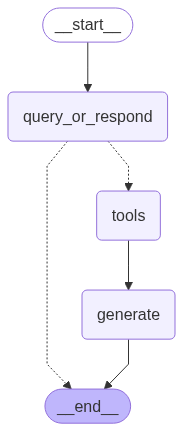

In [19]:
display(Image(graph.get_graph().draw_mermaid_png()))

#### Stream Chatbot Responses ####
Streaming helps make the application feel more responsive. It sshow intermediate progress; viz., to stream the output from the model token by token

In [29]:
# Specify a thread ID for the chat history - separate for each user/policy?
config = {"configurable": {"thread_id": "abc123"}}
input_message = "Hello, my name is SK"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, my name is SK
================================== Ai Message ==================================

Hello SK! How can I assist you today?


In [21]:
input_message = "Are gym memberships available?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Are gym memberships available?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Sb8uNFrsxg6qGZjUOOSSqzYN)
 Call ID: call_Sb8uNFrsxg6qGZjUOOSSqzYN
  Args:
    query: Are gym memberships available?
================================= Tool Message =================================
Name: retrieve

Source: {'page': 6, 'policy': 'gym-policy.pdf'}
Content: How much money can I save with corporate gym memberships? Savings range from 25% to
50% depending on the facility tier. For example, a typical $50 monthly gym membership might
cost you only $25-37.50 with our corporate discounts.
Can I use multiple gym memberships simultaneously? Generally, you can only have one active
corporate membership at a time, though you may be able to access diﬀerent locations within the
same network or chain.
What happens to my membership if I leave TechLance? Corporate discou

In [22]:
input_message = "How do i get one?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How do i get one?
================================== Ai Message ==================================

To get a gym membership, follow these steps:

1. **Browse Available Fitness Partners**: Go to the benefits portal to compare locations, amenities, class schedules, and member ratings of partner gyms.

2. **Select a Preferred Facility**: Choose the gym that best fits your needs.

3. **Complete Enrollment Process**: 
   - Upload required documents, including a recent pay stub or HR verification letter, photo identification, and emergency contact information.
   - Most gyms will also require you to complete a basic health questionnaire and a liability waiver.

4. **Payment Options**: You have two options for payment:
   - **Payroll Deduction**: This will automatically deduct membership fees from your paycheck using pre-tax dollars.
   - **Direct Payment**: You can pay the fitness center directly, which offers 